In [28]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

# import warnings
# warnings.filterwarnings("ignore")

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy as cgi
reload(cgi)

import misc_funs as misc

wavelength_c = 575e-9*u.m

nlam = 3
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

pixelscale_lamD = 0.2

iwa = 2.8
owa = 9.7

data_dir = cgi.data_dir

dm1_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

In [29]:
poppy.conf.use_cupy = True
poppy.conf.use_mkl = True
poppy.conf.use_fftw = True

# Test monochromatic PSFs.

Propagating wavelength 575.000 nm.


c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')


PSF calculated in 0.499s


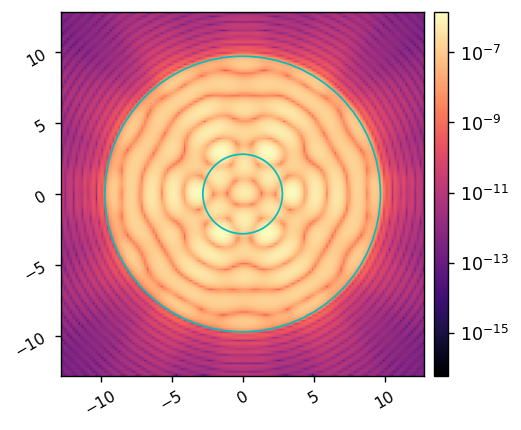

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\hlc_psf_575_gpu.fits


In [30]:
reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', 
              psf_pixelscale_lamD=pixelscale_lamD, npsf=128, 
              use_pupil_defocus=True, use_opds=False)

wf = hlc.calc_psf(quiet=False)
psf_575 = np.abs(wf)**2

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf_575, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(data_dir/'hlc_psf_575_gpu.fits', psf_575, header={'PIXELSCL':pixelscale_lamD})
else:
    misc.save_fits(data_dir/'hlc_psf_575_cpu.fits', psf_575, header={'PIXELSCL':pixelscale_lamD})

In [15]:
%%timeit
wf = hlc.calc_psf(quiet=True)

299 ms ± 778 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Propagating wavelength 575.000 nm.


c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')


PSF calculated in 0.606s


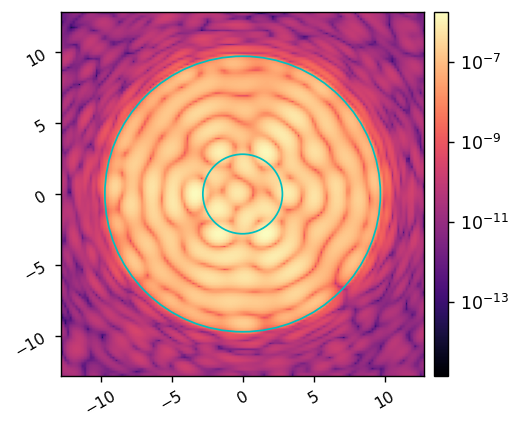

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\hlc_opds_psf_575_gpu.fits


In [31]:
hlc_opds = cgi.CGI(cgi_mode='hlc', 
                   psf_pixelscale_lamD=pixelscale_lamD, npsf=128, 
                   use_pupil_defocus=True, use_opds=True)

hlc_opds.set_dm1(dm1_flat)
hlc_opds.set_dm2(dm2_flat)

wf = hlc_opds.calc_psf(quiet=False)
psf_575 = np.abs(wf)**2

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf_575, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(data_dir/'hlc_opds_psf_575_gpu.fits', psf_575, header={'PIXELSCL':pixelscale_lamD})
else:
    misc.save_fits(data_dir/'hlc_opds_psf_575_cpu.fits', psf_575, header={'PIXELSCL':pixelscale_lamD})

In [22]:
%%timeit
wf = hlc_opds.calc_psf(quiet=True)

349 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test broadband PSFs with GPU parallelization.

### Create the actors to calculate each individual PSF/image with ray.remote() actors.

num_gpus can be set to whatever fractional GPU the user desires

In [41]:
kwargs = {'cgi_mode':'hlc',
          'psf_pixelscale_lamD':pixelscale_lamD,
          'npsf':128,
          'use_pupil_defocus':True,
          'use_opds':True}
actors = []
for i in range(nlam):
    actors.append(ray.remote(cgi.CGI).options(num_gpus=1/3).remote(wavelength=wavelengths[i], **kwargs))

### Calculate each image by calling the remote function of each actor. 

 pid=1468) After resampling, optic phasor shape (324, 324) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=21284) After resampling, optic phasor shape (324, 324) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=19604) After resampling, optic phasor shape (324, 324) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=21284) After resampling, optic phasor shape (405, 405) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=1468) After resampling, optic phasor shape (405, 405) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=19604) After resampling, optic phasor shape (405, 405) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=21284) After resampling, optic phasor shape (337, 337) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=21284) After resa

 pid=21284) After resampling, optic phasor shape (637, 637) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=21284) After resampling, optic phasor shape (637, 637) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=1468) After resampling, optic phasor shape (637, 637) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=1468) After resampling, optic phasor shape (637, 637) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=19604) After resampling, optic phasor shape (637, 637) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=19604) After resampling, optic phasor shape (637, 637) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=21284) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=1468) After resam

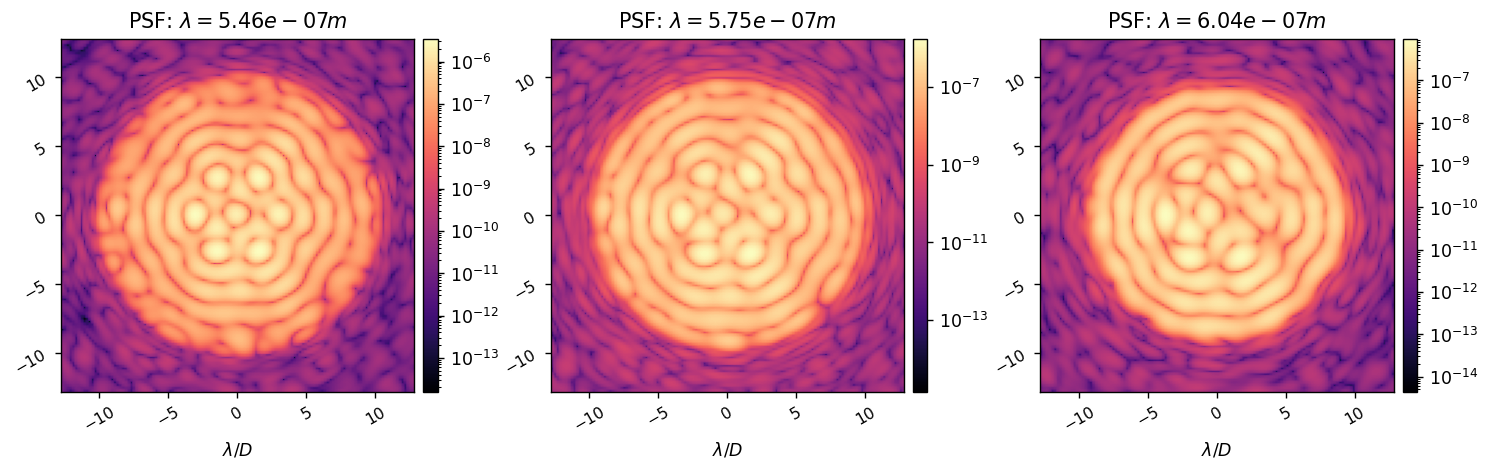

In [42]:
pending_ims = []
for i in range(len(actors)):
    actors[i].set_dm1.remote(dm1_flat) # set the DM state for each actor in this loop
    actors[i].set_dm2.remote(dm2_flat)
    future_ims = actors[i].snap.remote()
    pending_ims.append(future_ims)
ims = ray.get(pending_ims)
reload(misc)

misc.imshow3(ims[0], ims[1], ims[2], 
             'PSF: $\lambda={:.2e}$'.format(wavelengths[0]), 
             'PSF: $\lambda={:.2e}$'.format(wavelengths[1]),
             'PSF: $\lambda={:.2e}$'.format(wavelengths[2]),
             pxscl=hlc.psf_pixelscale_lamD, xlabel='$\lambda/D$',
             lognorm=True)

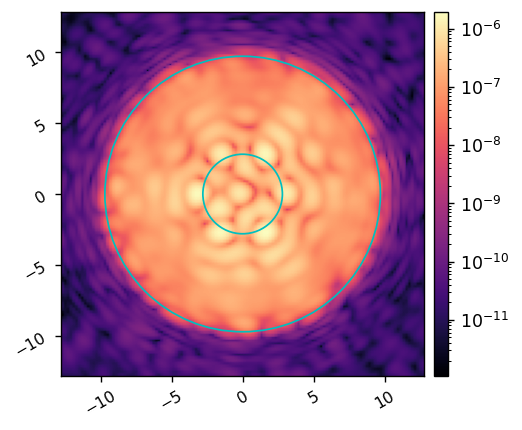

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\hlc_psf_broad_gpu.fits


In [43]:
psf_broad = 0
for i in range(nlam):
    psf_broad += ims[i]/nlam

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf_broad, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(data_dir/'hlc_psf_broad_gpu.fits', psf_broad, header={'PIXELSCL':pixelscale_lamD})
else:
    misc.save_fits(data_dir/'hlc_psf_broad_cpu.fits', psf_broad, header={'PIXELSCL':pixelscale_lamD})